In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from sbi.inference import infer
import sbi.utils as utils

In [55]:
N = 200

def f1(x, y, theta):
    a = theta[0]
    b = theta[1]
    return a * x - b * x * y

def f2(x, y, theta):
    c = theta[2]
    d = theta[3]
    return -c * y + d * x * y

def LV_EE(N, Y0, theta):
    dt = 0.5
    H = torch.zeros(N)
    P = torch.zeros(N)
    H[0] = Y0[0]
    P[0] = Y0[1]
    for n in range(N-1):
        H[n+1] = H[n] + dt * f1(H[n], P[n], theta)
        P[n+1] = P[n] + dt * f2(H[n], P[n], theta)
    return torch.cat([H, P], axis=0)

def simulator(theta):
    H0 = 2000
    P0 = 1000

    result = LV_EE(N ,[H0, P0], theta)
    
    return result + torch.randn_like(result) * 100

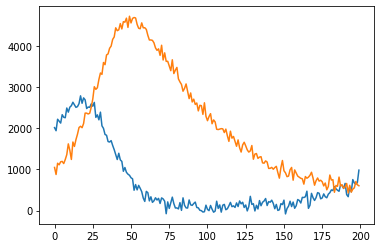

In [56]:
a=0.1
b=5e-5
c=0.04
d=b

theta = np.array([a, b, c, d])

result = simulator(theta)
    
plt.plot(result[:N])
plt.plot(result[N:])
plt.show()

In [57]:
num_dim = 4
prior = utils.BoxUniform(low=torch.zeros(num_dim), high=torch.ones(num_dim) * torch.tensor([0.5, 1e-4, 0.5, 1e-4]))

posterior = infer(simulator, prior, method='SNPE', num_simulations=1000)


Neural network successfully converged after 85 epochs.


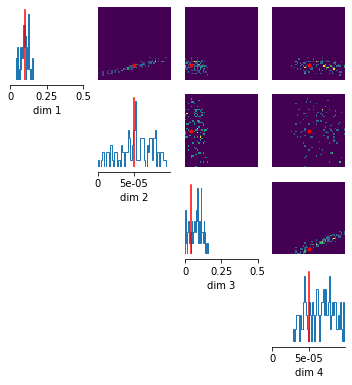

In [58]:
observation = simulator(theta)
samples = posterior.sample((100,), x=observation)
log_probability = posterior.log_prob(samples, x=observation)
_ = utils.pairplot(samples,
                   limits=[[0,0.5],[0,1e-4],[0,0.5], [0, 1e-4]],
                   points=theta,
                   points_offdiag={'markersize': 6},
                   points_colors='r',
                   fig_size=(6,6))